# LCF Churn Analysis #
### Author: Gabriel Trejos Durán ###
#### Disclosure: The code and analysis in this notebook is for exclusive use of LCF interview purposes. ####

## Background ##

After discussing with the potential client, the purpose of this analysis is to test the machine learning skills of a data science candidate. Given that the target audience is both my data science manager and/or the client, I have chosen to present the results in a Jupyter notebook for its visual interface that displays code, visualizations and analysis. 

The following analysis assumes that the client's objective is to reduce the churn rate potentially identify tailored actions given the information provided from the file. The dataset provided is likely to belong to a telecommunication or phone services company.

I want to clarify that in a real life scenario, before any coding, we would have a design thinking session or meeting with the client, an SME of the process to discuss the needs, objectives and address any questions about the variables. In this session, I will gather different information from the client, its customers,competition and obtain all the necessary information to have a solid background on the case. 

In [1]:
#Importing libraries

#For reading files
import pandas as pd 
import numpy as np 

#For visualization
import seaborn as sns
import matplotlib.pyplot as plt

#For feature engineering and model training
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import TomekLinks

#For explainability
from lime import lime_tabular

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Data Understanding ##

The dataset provided was given in excel file, with no metadata or further description of the variables. Although, normally a csv format is preferred for this type of analysis, I will work with the file provided since the formatting won't impact the analysis. 

In [2]:
# reading the file
df_churn = pd.read_excel("customer_churn_data.xlsx")  

# getting info of the dataset to look at the data types, number of rows and columns.
print(df_churn.info()) 
df_churn.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn(Target)
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Print unique values for each column
print(df_churn.apply(lambda x: pd.unique(x).tolist()))

#print only payment method 
print(df_churn.PaymentMethod.unique())

customerID          [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
gender                                                 [Female, Male]
SeniorCitizen                                                  [0, 1]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
tenure              [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
PhoneService                                                [No, Yes]
MultipleLines                             [No phone service, No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                         [No, Yes, No internet service]
OnlineBackup                           [Yes, No, No internet service]
DeviceProtection                       [No, Yes, No internet service]
TechSupport                            [No, Yes, No internet service]
StreamingTV                            [No, Yes, No internet service]
StreamingMovies     

The dataset consists of 7043 rows and 21 different columns, with the Churn (Target) as the dependent variable, and the other 20 as independent.

Here is a brief description of the dataset: 

### Dependent Variable: 

Churn: Binary value whether the customer cancelled the contract/service. 

### Independent Variables: 

#### Demographic Variables: 

These variables give demographic info of the client.

Gender: Male or Female

Senior Citizen: Whether the client is considered a senior citizen.

Partner: If client is single or not. 


#### Main Services: 

Phone Service: (Yes,No)

MultipleLines: (Yes, No, No Phone Service)

Internet Service provided: (DSL,FiberOptic,or No Phone Service)

#### Additional Support Services:  

OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies. 

All of these variables take these three categories: (Yes, No, No internet service)

These are probably complementary services that client signs which are not part of the main services. 

#### Billing: 

These are varibles related to payments and billing. 

Contract: Type of contract (Month-to-month, One year, Two year)

PaperlessBilling: Whether the client receives the invoices by paper or not.

PaymentMethod: The method used by client to pay: ('Electronic check' 'Mailed check' 'Bank transfer (automatic)'
'Credit card (automatic)')

Tenure: Months of contract from the client. Could also be days, but given there is a monthly charge column, these are likely months. 

Monthly Charges: Charges per month based on the services

Total Charges: Total charges which are the result of the monthly charge times the tenure.

                       
                       





## Data Preprocessing ##

Looking at the data types, one thing that stood out is that the Monthly Charges are float values and Total Charges coded as object. I will change this to be able to work with this column. The Customer ID does not seem to add value to the analysis, so I will drop it. I will also rename the dependent variable to Churn, since the word "Target" was meant to serve as a guide to the exercise. 

One last thing in terms of improving the data quality is that the formula of the total charges should be the tenure times the monthly charges. Upon asking the client, he said to work with the data as it is and assume the extra amount is due to some taxes or hidden fees. 

### Data Cleaning

In [4]:
# Convert 'TotalCharges' column from object to float
df_churn['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors='coerce').astype('float64')

#Rename Churn column
df_churn.rename(columns = {'Churn(Target)':'Churn'}, inplace = True) 

# Remove the 'customerID' column
df_churn.drop(['customerID'], axis=1, inplace=True)
print(df_churn.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


### Handling Missing Values

In [5]:
# Check the number of missing values
print(df_churn.isnull().sum().sort_values(ascending=False))

TotalCharges        11
gender               0
SeniorCitizen        0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
DeviceProtection     0
OnlineBackup         0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
Churn                0
dtype: int64


The number of missing values is less than 0.25% of all the dataset. With such low percentage of missing values, the best treatment is to drop. Normally, with other projects I like to use imputation methods with unsupervised learning model or by applying some interpolation. 

In [6]:
# Remove rows with missing values
df_churn.dropna(inplace=True)

# Check if there are still missing values in 'TotalCharges' column
print(df_churn.loc[df_churn['TotalCharges'].isnull() == True])

Empty DataFrame
Columns: [gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []


### Outliers Detection

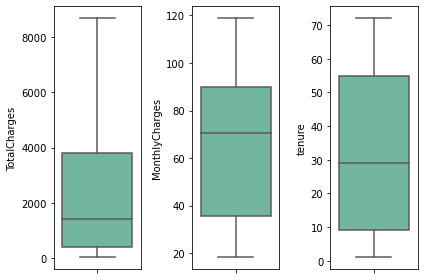

In [7]:
#Create a function to display boxplots
def boxplots(df_churn):
    fig, axes = plt.subplots(1,3)
    sns.boxplot(y="TotalCharges", data=df_churn,ax=axes[0],palette = "Set2")
    sns.boxplot(y="MonthlyCharges", data=df_churn,ax=axes[1],palette = "Set2")
    sns.boxplot(y="tenure", data=df_churn,ax=axes[2],palette = "Set2")
    fig.tight_layout()
boxplots(df_churn)

Looking at the boxplots, there is no presence of outliers in the numeric variables. Potentially it might be a good idea to look at the total charges by churn since the variables will be encoded for modeling, but for now I will be treating the variable as whole.

## Exploratory Data Analysis ##

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


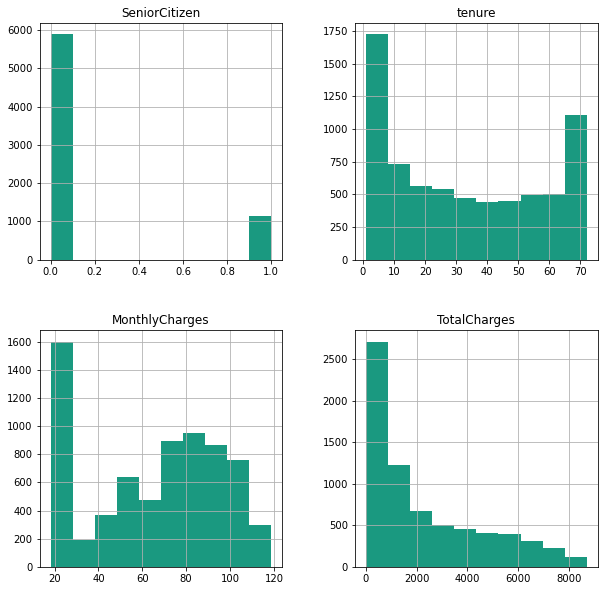

In [8]:
# Plot histograms of all the numeric columns
df_churn.hist(figsize=(10, 10),color=(0.1,0.6,0.5))
df_churn.describe()

Looking at the statistical information of the numerical variables, I can tell that the data is not normally distributed, with Tenure and Monthly charges showing a bimodal distribution and TotalCharges skewed to the right. There are also different ranges of values, especially with the total charges and should be normalized before modeling. In terms of monthly charges most clients are paying monthly charges less than $30. 

One variable that is potentially associated with the churn rates is tenure. Looking at the bimodal distribution it looks like the company is good at capturing new clients and has a good number of loyal ones but it is having a hard retaining after a year. Additionally, it looks like less than 15% of the total number of clients are non senior. One potential assumption is that younger clients could have an impact in the tenure of contracts and thus the churn rate, but without age information is also hard to segregate the over 5000 non senior citizens. 


## Class Balance  ##

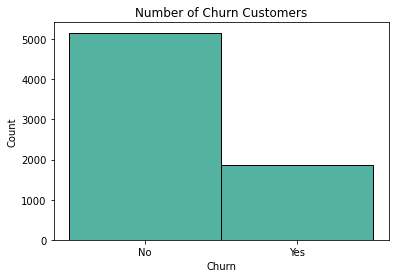

In [9]:
#Plot dependent variable to check class balances

sns.histplot(data=df_churn, x='Churn',color=(0.1,0.6,0.5))
plt.title('Number of Churn Customers')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

The plot clearly shows that the dataset is imbalanced with less than 20% of all the data labeled as churned and the rest as clients that have not churned. This class imbalanced will most likely affect the performance of the model. At this moment, I will continue to analyze the data as it is imbalanced and then will perform some resampling using oversampling or undersampling techniques.

In [10]:
#Create a function to display stacked plots

def stacked_plots(df, columns):
    """
    Plots stacked countplots for each column
    """
    num_cols = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(num_cols * 5, 5))
    for i, column in enumerate(columns):
        total_counts = df[column].value_counts()
        churn_counts = df.groupby([column, 'Churn'])[column].count().unstack()
        churn_rates = churn_counts.div(total_counts, axis=0) * 100
        churn_rates.plot(kind='bar', stacked=True, ax=axes[i], cmap='Set2')
        axes[i].set_title(column)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Churn Rate (%)')
        axes[i].legend(loc='upper right')

    plt.tight_layout()

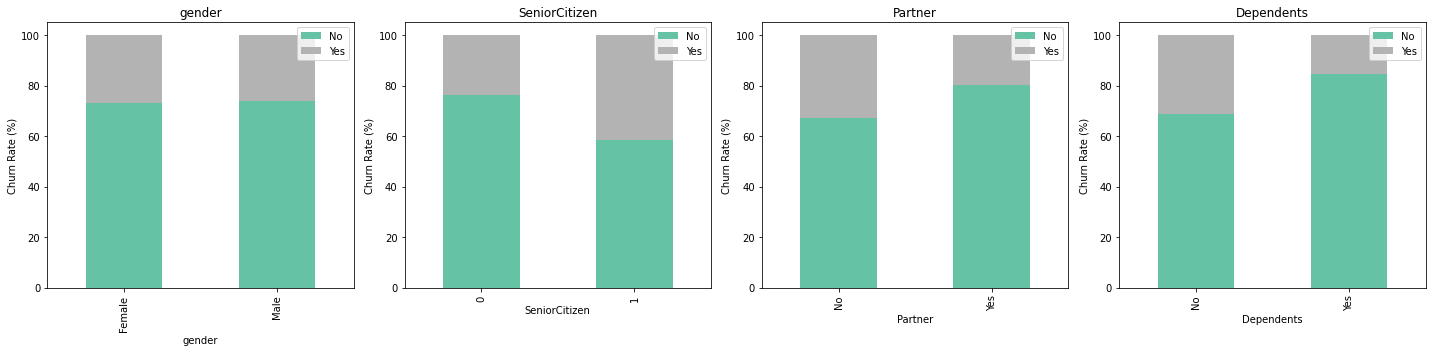

In [11]:
demographic = df_churn[['gender', 'SeniorCitizen', 'Partner', 'Dependents']]
stacked_plots(df_churn,demographic.columns)

From the demographic information, I can tell that gender is most likely to not have any relation to the churn rates, the ratio of churn rates by gender are pretty much the same. Looking at the churn rate among senior citizens is higher compared to non senior citizens, although in absolute terms, the amount of non senior citizens is very little compared to non. Single customers churn more than than ones with a partner. Finally, not having dependents seem to have a higher influnce in churning. 

In summary, clients who are older, single and have no kids seem to have a higher impact on churn rates.

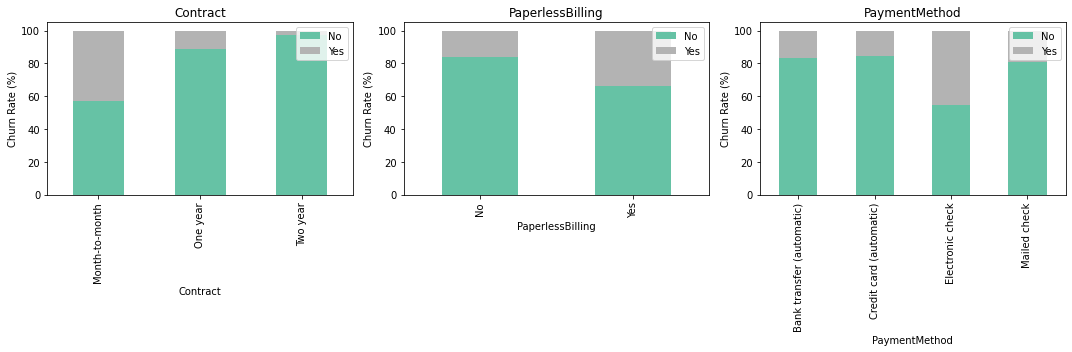

In [12]:
billing=df_churn[['Contract', 'PaperlessBilling', 'PaymentMethod']]
stacked_plots(df_churn,billing.columns)

In terms of billing, month to month contracts are significantly more likely to churn compared to the ones for one or two years. Customers who receive a paper billing are less likely to leave the company. Finally, automatic payments are less likely to make clients drop out compared to any other form of payment, especially electronic checks.

I also plotted tenure under this category, but the plot was not the best due to continuous nature of the variables. I will group the tenure by year and plot the graph separately to display the churn rates.

<Figure size 720x432 with 0 Axes>

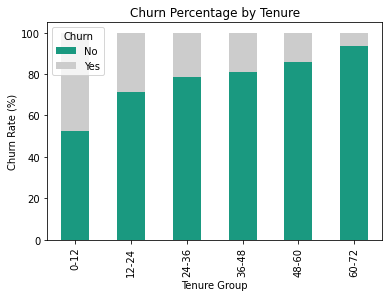

In [13]:
#Define labels and bins for tenure groups
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ["0-12", "12-24", "24-36", "36-48", "48-60", "60-72"]

# Create the tenure_grouped column
df_churn['tenure_grouped'] = pd.cut(df_churn.tenure, bins=bins, labels=labels)

# Group the data by tenure_grouped and calculate the churn rate for each group
churn_by_tenure = df_churn.groupby('tenure_grouped')['Churn'].value_counts(normalize=True).unstack() * 100

# Create a stacked bar plot of churn by tenure
plt.figure(figsize=(10, 6))
ax = churn_by_tenure.plot(kind='bar', stacked=True, color=[(0.1,0.6,0.5), (0.8,0.8,0.8)])
ax.set_xlabel('Tenure Group')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Percentage by Tenure')
plt.show()

Looking at the the graph, it can be observed that costumers with tenures less than a year have the highest churn rate, with almost half of the clients churning. Tenure seems to have a negative correlation with Churn Rates i.e. the higher the tenure, the lower the churn rate. If we add this to the fact that the type of contract with highest churn rates is the month to month, one could hypothesize that clients are dropping within the first year, which could indicate the quality service is not sufficient to renew after a year or cancel it before. 

I will look at the different services to see if there is any specific service that could explain why clients churn so soon.

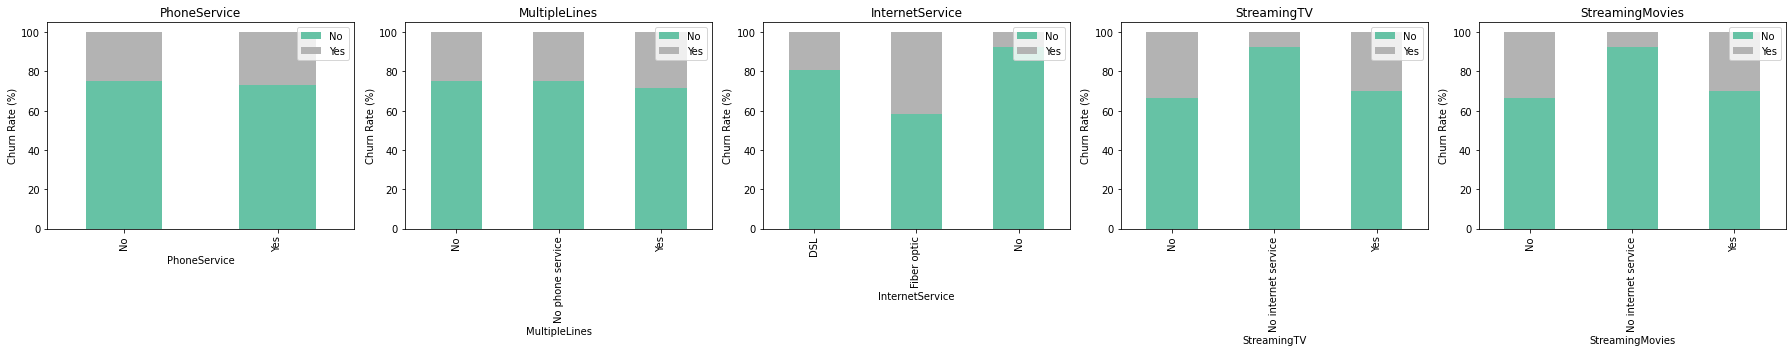

In [14]:
services=df_churn[['PhoneService', 'MultipleLines', 'InternetService','StreamingTV', 'StreamingMovies']]
stacked_plots(df_churn,services.columns)

Both phone services and multiple lines do not seem to have a high influence on the churn rates. In terms of the internet service, having fiber optic seems to have a high influence on the churn rates. Both streaming movies and streaming TV seem to highly related, thus the same pattern of churn rate, none which seem to be adding any predictive power to the potential models.

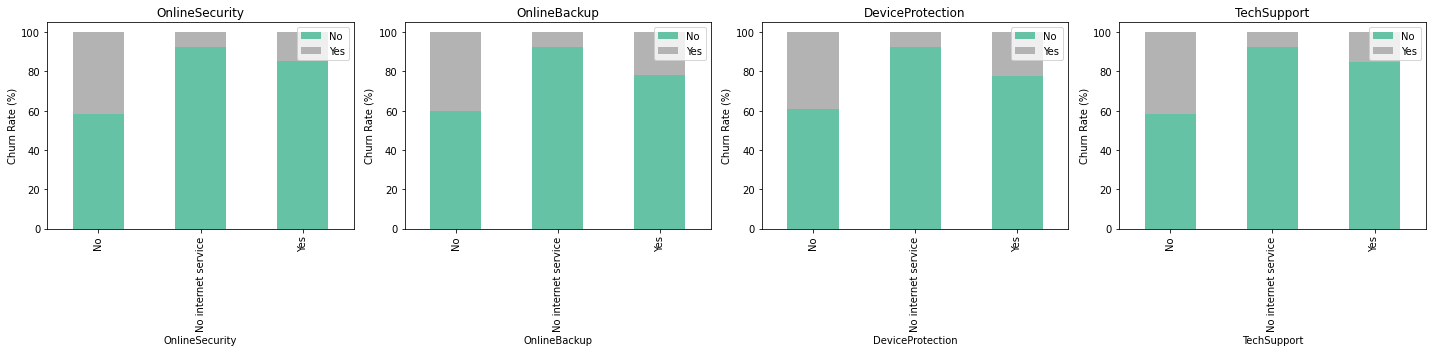

In [15]:
support=df_churn[['OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport']]
stacked_plots(df_churn,support.columns)

In terms of support services, the pattern seems to be consistent among all four services, with customer not opting for these more likely to churn. It is also worth noting that churn behaviour is pretty much the same, which could be an indication that either these services are offered/chosen as a bundle or that the client has the same behaviour in terms of seeing these as a plus and not a necessity. 

Text(0.5, 1.0, 'Distribution of Total Charges by Churn')

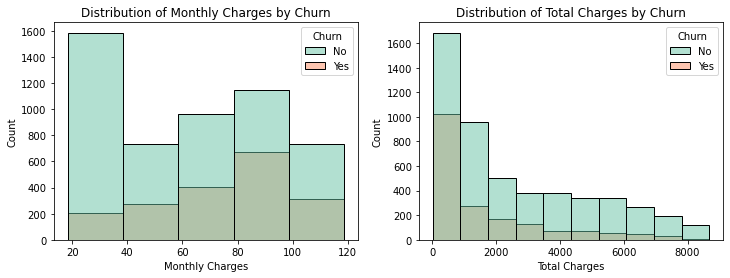

In [16]:
f, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(df_churn, x="MonthlyCharges", hue="Churn", ax=ax[0], palette='Set2',bins=5)
sns.histplot(df_churn, x="TotalCharges", hue="Churn", ax=ax[1], palette='Set2',bins=10)

ax[0].set_xlabel('Monthly Charges')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of Monthly Charges by Churn')

ax[1].set_xlabel('Total Charges')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of Total Charges by Churn')

These last visualizations show the churn count by the charges. Customers with monthly charges betwen 80 and  100 dollars are more like to churn that with any other amount. In terms of total charges, clients with less than 500 dollars in total charges show a significant more likelihood of canceling the services that with any other bracket. Given that total charges are a function of tenure, this makes sense that it is also a variable with potential predictive power. Also, it shows that these variables are highly correlated between them.

## Feature Engineering and Scaling ##

For feature engineering, I will replace the dependent variables for 1 and 0, encode all the categorical variables to 1 and 0s and finally normalize the variables different ranges such as TotalCharges and Monthly Charges using the standardscaler.

In [17]:
def feature_eng(df_churn):
    # Make a copy of the DataFrame 
    df = df_churn.copy()

    # Replace 'Yes' and 'No' values in 'Churn' column with 1 and 0 respectively
    df['Churn'].replace({'Yes': 1, 'No': 0}, inplace=True)

    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df)

    # Separate the target variable from features
    y = df_encoded['Churn'].values
    X = df_encoded.drop(columns=['Churn'])

    # Standardize the features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X,y

X, y = feature_eng(df_churn)

## Modeling ##

I will create a training function with three different classifier models, which are commonly used. The dataset will be split to train the models with 70% of the dataset. Through the chosen_model function, the best model will be selected for hyperparameter tuning. At this point, I will only chose the model based on its accuracy score. 

In [18]:
def training():
    #split training and testing dataset using 30% for testing and takes encoded values as inputs
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

    #Create list of models
    models = [
         LogisticRegression(),
         RandomForestClassifier(),
         GradientBoostingClassifier()
         ]
    
    return models, X_train, X_test, y_train, y_test

models, X_train, X_test, y_train, y_test = training()

In [19]:
def chosen_model():
    best_acc = 0
    best_model = None
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{type(model).__name__} accuracy: {acc}")
        cm = confusion_matrix(y_test, y_pred)
        print(f"{type(model).__name__} confusion matrix:")
        print(cm)
        print(classification_report(y_test, y_pred))
        if acc > best_acc:
            best_acc = acc
            best_model = model

    print(f"\nThe best classifier is {type(best_model).__name__} with an accuracy of {best_acc}")

chosen_model()

LogisticRegression accuracy: 0.8146919431279621
LogisticRegression confusion matrix:
[[1436  144]
 [ 247  283]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1580
           1       0.66      0.53      0.59       530

    accuracy                           0.81      2110
   macro avg       0.76      0.72      0.74      2110
weighted avg       0.81      0.81      0.81      2110

RandomForestClassifier accuracy: 0.795734597156398
RandomForestClassifier confusion matrix:
[[1415  165]
 [ 266  264]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1580
           1       0.62      0.50      0.55       530

    accuracy                           0.80      2110
   macro avg       0.73      0.70      0.71      2110
weighted avg       0.78      0.80      0.79      2110

GradientBoostingClassifier accuracy: 0.8061611374407583
GradientBoostingClassifier confusion matrix:
[[1426  154]
 

From the three models the model with the best performance was the Gradient Boosting Classifier with an accuracy of 80%. One thing that all three models had in common is that none were able to generalize well the dataset with clients that have churned, which is reflected in the low recall scores. The best explanation for this is due to the class imbalance, which will be addressed after the hyperparameter tuning.

## Hyperparameter Tuning ##

In this final section, I will perform some hyperparameter tuning to try and improve the model's performance using RandomizeSearchCV with the best performing model (Gradient Boosting Classifier). Once the parameters have been selected, they will be pased the best model.

In [20]:
#defining the grid parameters
grid_parameters = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50,100,130,150],
    'max_depth': [3, 4, 5, 6],
    'max_features': ['auto', 'sqrt', 'log2','None'],
    'min_samples_split': [2, 3, 4, 5]}


# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
    param_distributions=grid_parameters,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=50,
    n_jobs=-1)

def tuned_model(X_train,y_train):
    #global variable
    global best_model
    
    # fitting the model for random search
    random_search.fit(X_train, y_train)

    # Get the best model and its hyperparameters
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(f"Confusion matrix:\n{confusion}")
    print(classification_report(y_test, y_pred))


tuned_model(X_train,y_train)


Accuracy: 0.8109004739336493
Confusion matrix:
[[1432  148]
 [ 251  279]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1580
           1       0.65      0.53      0.58       530

    accuracy                           0.81      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110



After the hyperparameter tuning, the model barely improved its performance by ~1%. On the other hand it also improved slightly its recall score. 

In [21]:
#Resampling using TomekLinks to address class imbalances
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X_train, y_train)

tuned_model(X_tl,y_tl)

Accuracy: 0.8028436018957346
Confusion matrix:
[[1373  207]
 [ 209  321]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1580
           1       0.61      0.61      0.61       530

    accuracy                           0.80      2110
   macro avg       0.74      0.74      0.74      2110
weighted avg       0.80      0.80      0.80      2110



Resampling the dataset with the tuned model did improve the recall score for churn rates, but reduced the overall accuracy. Since the objective of this client is to improve is churn rates, a better recall score is prefered than the maintaining overall accuracy, as it will reduce the number of false negatives and be able to better identify clients likely to churn.

In [22]:
scores = cross_val_score(best_model, X_train, y_train, cv = 5, scoring ='accuracy')
Cross_validated_ROC_AUC = cross_val_score(best_model, X_train, y_train, cv = 5, scoring = 'roc_auc').mean()

print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))
print('Cross-validation scores:{}'.format(scores))

Cross validated ROC AUC : 0.8540
Cross-validation scores:[0.80406091 0.80101523 0.79369919 0.81199187 0.80284553]


After performing the hyperparameter tuning and resampling the dataset, the validation scores are very close to the testing scores, which is a good indication that there is no potential overfitting with the model. At the same time there is a room for futher iterations to improve the model's performance.

Given that the purpose of this test is to evaluate the end to end process and not to get to the highest model's accuracy possible, I will not perform further iterations and tune more the hyperparameters. However, some potential improvements that could be done is to reduce the features used for training to reduce the model's complexity, try other resampling techniques to balance the classes or create/add new features with higher predictive power.

## Model Explainability ##

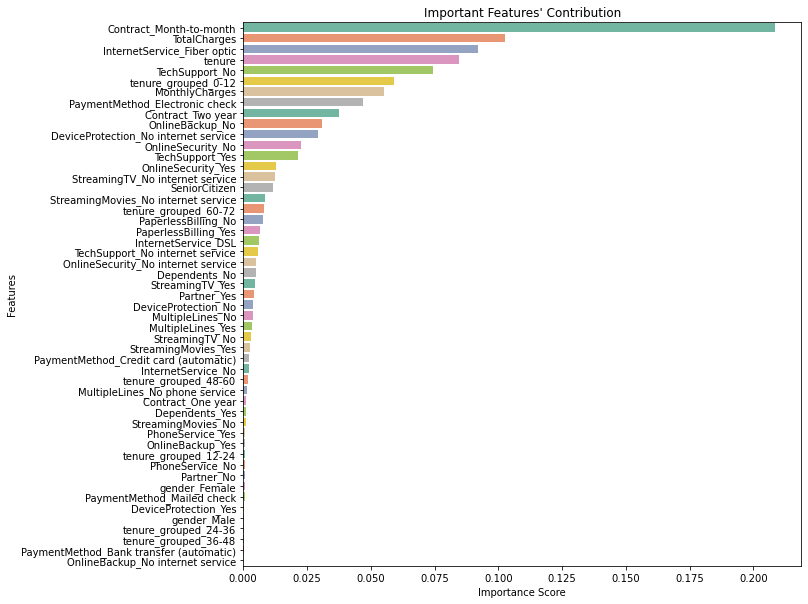

In [23]:
#Retrieving feature importance
feature_imp = pd.Series(best_model.feature_importances_,index=X_train.columns).sort_values(ascending=False)

#plot feature importance
plt.figure(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index,palette='Set2')

# Adding labels
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title("Important Features' Contribution")

plt.show()

The graph shows that, for the Gradient Boosting Classifier model, the features that had the highest predictive power were the contract month to month, followed by internet fiber optic, and total charges. By looking at the features, one possibility to improve the model in future iterations is to drop some of the features with no predictive power such as the support services, that could potentially be affecting the model's perfomance by making it to complex to generalize the data. Also it would be important to address the issue of multicolinearity with variables such as tenure and total charges, among others.

## Deployment ##

In [24]:
def pred_explain():
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        class_names=['Yes', 'No'],
        mode='classification')

    exp = explainer.explain_instance(
        data_row=X_test.iloc[1], 
        predict_fn=best_model.predict_proba)
    exp.show_in_notebook(show_table=True)
    
pred_explain()

One thing that it is important for me in terms of model explainability is not only at explaining the model itself, but also the predictions made by the model. By using the Lime library, the potential client could understand the key features for each of the class predictions as well as their weights. For instance one of the testing dataset, the user can see that the model predicted that a customer with this permuation of features is 86% likely to churn and the feature with the highest weight to explain this probability is the Fiber Optic. 

Most deployments for classification cases will be very similar to the Lime's visualization in which the customer can see the likelihood of each of the classes. 

Although, not required for this exercise, this model once deployed, monitoring will be required to ensure there is no data drift from changes in the data.

## Conclusions

As a result the data analysis performed and the model's feature weights, we can conclude that customers with month to month contracts are more likely to churn than customers who chose other modalities. 

Based on these results here are some suggestions the client to take the following actions:

1) Change the duration of contracts or offer incentives such as discounts for multi-month contracts.
    
2) Evaluate the quality and pricing of the fiber optic service. From the EDA analysis on total charges, it was observed that     clients with monthly charges between 60 and 100 dollars per month were more likely to churn. Given that Fiber Services are       within that price range, this could be one of the services the client is not satisfied with. 

## Future Recommendations

Use Metadata: We know from the model that month to month contracts have the highest predictive power in terms of churning. However, this does not give us a root cause as to why month to month clients churn more than long term. We could potentially work with the company to conduct customer surveys or complaints, and perform some text analytics to identify what are the real drivers behind the high churn rates for month to month contracts. This could give us more insights on the customer experience with each of the services and the perceived quality of each. Concomitantly, more demographic data can be gathered such as the age of the customers, location, reason for acquiring services, etc. 
    
Treat Multicolinearity: I did not treat the model for multicollinearity, but it is very likely that different variables are highly correlated. For example, tenure and total charges are probably highly correlated, given that one variable is part of the function of the other. A similar case is for all the techsupport services  that might have some degree of multicollinearity, with clients opting these services together or even offered as a bundle.

Timestamps: The analysis done is static in time. We do not know the time context of the data and whether there are seasonal patterns with churn. This dataset could be at the beginning of the year or after a big campaign to capture new clients.